# Train MLP with PyTorch

In [52]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class PendulumDataset(Dataset):
    def __init__(self, csv_file):
        # Read the CSV file (no header row)
        df = pd.read_csv(csv_file, header=None)

        # Convert each column to a numeric type, coerce errors to NaN
        df = df.apply(pd.to_numeric, errors='coerce')
        # Drop any rows that contain NaN (from invalid conversions)
        df = df.dropna()

        # Rename columns for convenience
        df.columns = ["theta", "theta_dot", "control", "theta_next", "theta_dot_next"]
        
        # Now extract input features and targets
        self.X = df[["theta", "theta_dot", "control"]].values
        self.y = df[["theta_next", "theta_dot_next"]].values
        
        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------------------
# 2. Define the MLP Model in PyTorch
# -------------------------------
class PendulumMLP(nn.Module):
    """
    A simple feedforward neural network (MLP) to predict
    (theta_next, theta_dot_next) from (theta, theta_dot, control).
    """
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=2):
        super(PendulumMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


# ---------------
# 3. Train Model
# ---------------
def train_model(
    model,
    train_loader,
    num_epochs=50,
    lr=1e-3,
    device="cpu"
):
    # Use Mean Squared Error loss
    criterion = nn.MSELoss()
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Move model to device (CPU or GPU)
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
        
        # Compute average loss over this epoch
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    
    print("Training complete.")


# Hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 1e-3

# Initialize dataset and dataloader
dataset = PendulumDataset("./data/pendulum_dataset.csv")
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate model
model = PendulumMLP(input_dim=3, hidden_dim=64, output_dim=2)

# Train the model
train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="cuda")

# Example: After training, let's do a quick inference on the first sample
model.eval()



Epoch [1/100], Loss: 13.240701
Epoch [2/100], Loss: 4.145870
Epoch [3/100], Loss: 2.585673
Epoch [4/100], Loss: 1.973272
Epoch [5/100], Loss: 1.654601
Epoch [6/100], Loss: 1.383066
Epoch [7/100], Loss: 1.056985
Epoch [8/100], Loss: 0.757407
Epoch [9/100], Loss: 0.462893
Epoch [10/100], Loss: 0.275824
Epoch [11/100], Loss: 0.164249
Epoch [12/100], Loss: 0.098897
Epoch [13/100], Loss: 0.064827
Epoch [14/100], Loss: 0.043643
Epoch [15/100], Loss: 0.034218
Epoch [16/100], Loss: 0.029156
Epoch [17/100], Loss: 0.023500
Epoch [18/100], Loss: 0.020937
Epoch [19/100], Loss: 0.018450
Epoch [20/100], Loss: 0.019695
Epoch [21/100], Loss: 0.016398
Epoch [22/100], Loss: 0.014418
Epoch [23/100], Loss: 0.018281
Epoch [24/100], Loss: 0.013340
Epoch [25/100], Loss: 0.016638
Epoch [26/100], Loss: 0.012507
Epoch [27/100], Loss: 0.012070
Epoch [28/100], Loss: 0.013383
Epoch [29/100], Loss: 0.011753
Epoch [30/100], Loss: 0.011436
Epoch [31/100], Loss: 0.011317
Epoch [32/100], Loss: 0.011944
Epoch [33/100], 

PendulumMLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [53]:
for i in range(dataset.X.shape[0]):
    X_sample, y_sample = dataset[i]
    with torch.no_grad():
        y_pred = model(X_sample.unsqueeze(0).to(model.net[0].weight.device))  # unsqueeze for batch dimension and move to device
    print(f"Sample {i}:")
    print(f"Input (theta, theta_dot, control)    = {X_sample}")
    print(f"Meas (theta_dot, theta_ddot)   = {y_sample}")
    print(f"Predicted (theta_dot, theta_ddot) = {y_pred.squeeze(0)}")


Sample 0:
Input (theta, theta_dot, control)    = tensor([-1.1459,  4.7426, -1.2175])
Meas (theta_dot, theta_ddot)   = tensor([  4.7361, -10.1390])
Predicted (theta_dot, theta_ddot) = tensor([ 4.7399, -9.9376], device='cuda:0')
Sample 1:
Input (theta, theta_dot, control)    = tensor([5.1842, 4.6421, 1.8392])
Meas (theta_dot, theta_ddot)   = tensor([ 4.6543, -6.8855])
Predicted (theta_dot, theta_ddot) = tensor([ 4.6567, -6.8986], device='cuda:0')
Sample 2:
Input (theta, theta_dot, control)    = tensor([ 5.2303e+00,  4.5741e+00, -1.7529e-03])
Meas (theta_dot, theta_ddot)   = tensor([ 4.5469, -8.5453])
Predicted (theta_dot, theta_ddot) = tensor([ 4.5624, -8.5196], device='cuda:0')
Sample 3:
Input (theta, theta_dot, control)    = tensor([ 5.2756,  4.4900, -1.3655])
Meas (theta_dot, theta_ddot)   = tensor([ 4.4939, -9.6769])
Predicted (theta_dot, theta_ddot) = tensor([ 4.4405, -9.6956], device='cuda:0')
Sample 4:
Input (theta, theta_dot, control)    = tensor([5.3201, 4.3946, 0.2848])
Meas (t

MSE Theta:      9.551098
MSE Theta_Dot:  11.336835


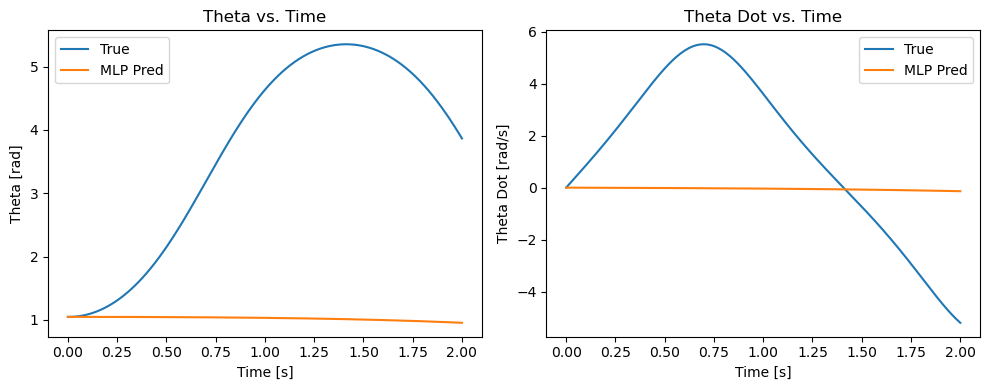

In [54]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def simulate_ground_truth(theta0, theta_dot0, control=0.0, dt=0.01, steps=100):
    """
    Simulate the pendulum with known/analytical dynamics or from
    your own ground-truth data. Replace this function with your actual
    simulator or real data lookup if necessary.
    
    Returns:
      theta_traj, theta_dot_traj (both numpy arrays of length `steps+1`)
    """
    # For a simple pendulum: theta_ddot = -(g / L) * sin(theta) + control
    # Just an example. Not guaranteed to match your data exactly!
    g = 9.81
    L = 1.0
    
    theta_traj = np.zeros(steps + 1)
    theta_dot_traj = np.zeros(steps + 1)
    theta_traj[0] = theta0
    theta_dot_traj[0] = theta_dot0
    
    for t in range(steps):
        theta = theta_traj[t]
        theta_dot = theta_dot_traj[t]
        
        # Example dynamics, ignoring damping or friction:
        theta_ddot = (g/L) * np.sin(theta) + control

        # Euler integration:
        theta_dot_new = theta_dot + theta_ddot * dt
        theta_new = theta + theta_dot * dt
        
        theta_traj[t+1] = theta_new
        theta_dot_traj[t+1] = theta_dot_new

    return theta_traj, theta_dot_traj


def simulate_mlp(model, theta0, theta_dot0, control=0.0, dt=0.01, steps=100, device='cuda:0'):
    """
    Use the trained MLP (which outputs ddtheta) to roll out predictions
    for multiple steps via Euler integration.
    
    Returns:
      theta_pred, theta_dot_pred (numpy arrays of length `steps+1`)
    """
    model.eval()  # set model to evaluation mode
    
    theta_pred = np.zeros(steps + 1)
    theta_dot_pred = np.zeros(steps + 1)
    
    theta_pred[0] = theta0
    theta_dot_pred[0] = theta_dot0
    
    with torch.no_grad():
        for t in range(steps):
            th_t = theta_pred[t]
            thd_t = theta_dot_pred[t]

            # Prepare input to MLP
            # shape (1,3) => [theta, theta_dot, control]
            curr_input = torch.tensor([th_t, thd_t, control], dtype=torch.float32).to(device)
            curr_input = curr_input.unsqueeze(0)

            # MLP outputs ddtheta (shape (1,2))
            ddtheta = model(curr_input)
            ddtheta = ddtheta.squeeze(0).cpu().numpy()
            ddtheta = ddtheta[0] 
            
            # Euler integration for next step
            theta_dot_pred[t+1] = thd_t + ddtheta * dt
            theta_pred[t+1] = th_t + thd_t * dt
    return theta_pred, theta_dot_pred


def compare_trajectories(model, theta0, theta_dot0, control=0.0, steps=100, dt=0.01):
    """
    Compare the MLP-based trajectory vs. ground truth
    and optionally plot the results.
    """
    # 1) Generate or load the ground truth trajectory
    theta_true, theta_dot_true = simulate_ground_truth(theta0, theta_dot0, control=control, dt=dt, steps=steps)
    
    # 2) Roll out MLP predictions
    theta_mlp, theta_dot_mlp = simulate_mlp(model, theta0, theta_dot0, control=control, dt=dt, steps=steps)
    
    # 3) Compute error metrics (e.g., MSE)
    mse_theta = np.mean((theta_true - theta_mlp)**2)
    mse_theta_dot = np.mean((theta_dot_true - theta_dot_mlp)**2)
    print(f"MSE Theta:      {mse_theta:.6f}")
    print(f"MSE Theta_Dot:  {mse_theta_dot:.6f}")
    
    # 4) Plot the two trajectories for visual inspection
    t_vals = np.linspace(0, steps*dt, steps+1)
    plt.figure(figsize=(10, 4))
    
    # Plot theta
    plt.subplot(1, 2, 1)
    plt.plot(t_vals, theta_true, label='True')
    plt.plot(t_vals, theta_mlp, label='MLP Pred')
    plt.title("Theta vs. Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Theta [rad]")
    plt.legend()
    
    # Plot theta_dot
    plt.subplot(1, 2, 2)
    plt.plot(t_vals, theta_dot_true, label='True')
    plt.plot(t_vals, theta_dot_mlp, label='MLP Pred')
    plt.title("Theta Dot vs. Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Theta Dot [rad/s]")
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# 2) Choose initial condition
theta0 = np.pi/3 # Initial angle (also in dataset)
theta_dot0 = 0.0

# 3) Compare MLP rollout with (some) ground truth simulator
compare_trajectories(model, theta0, theta_dot0, control=0.0, steps=200, dt=0.01)

# MSE Theta:      9.334476
# MSE Theta_Dot:  11.414437